# Introduction

This project addresses the take-home challenge component of the data-science interview process for Relax, Inc. The thrust of the project is to identify factors that predict future user adoption, where user adoption is defined as logging into the product on three separate days in at least one seven-day period. 

# Data Wrangling

Here, I will read in the engagment dataset, check for missing values, and perform any other cleaning that might be needed.

In [168]:
import pandas as pd
import numpy as np

engage = pd.read_csv('takehome_user_engagement.csv')
engage.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [169]:
#check number of unique users 
print(len(engage.user_id.unique()))

8823


In [54]:
# check for missing data -- none! 
print(engage.isnull().values.any())

False


In [55]:
# visited column appears to have no use at this point 
print(engage.visited.unique()) 

[1]


In [72]:
# drop visited column 
engage.drop(['visited'], axis=1, inplace=True)

In [75]:
# adjust df so that time stamp is index w/ monotonic increase
# mark adopted users (logged in 3 discrete days within a 7-day period)
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'], format="%Y-%m-%d %H:%M:%S.%f", 
                                          exact=True, utc=True) # require exact format match; use UTC time
engage.index = pd.DatetimeIndex(engage.time_stamp, inplace=True) #make time stamp the index
eng_ind = engage.sort_index() #sort by index labels 
eng_ind.drop(eng_ind.columns[0], axis=1, inplace=True)

print (eng_ind.index.is_monotonic_increasing) # need monotonic increase to use rolling method in groupby
eng_ind.head()

True


,user_id
time_stamp,
2012-05-31 08:20:06,10012
2012-05-31 15:47:36,3428
2012-05-31 17:19:37,9899
2012-05-31 21:58:33,1693
2012-06-01 00:17:30,6102


In [125]:
# find adopted users (logged in on 3 different days in 7-day period)
adopt = eng_ind.groupby('user_id').rolling(window='7d', min_periods=3).sum().fillna(0)

In [126]:
# add column to flag adopted users (df does better w/ this step in separate cell)
adopt['adopted'] = np.where(adopt['user_id']>0, 1, 0)
adopt.rename(columns={'user_id': 'id'}, inplace=True) #create separate name for dropping later
adopt.head(10)

id  adopted
user_id time_stamp                       
1       2014-04-22 03:53:30  0.0        0
2       2013-11-15 03:45:04  0.0        0
        2013-11-29 03:45:04  0.0        0
        2013-12-09 03:45:04  0.0        0
        2013-12-25 03:45:04  0.0        0
        2013-12-31 03:45:04  0.0        0
        2014-01-08 03:45:04  0.0        0
        2014-02-03 03:45:04  0.0        0
        2014-02-08 03:45:04  0.0        0
        2014-02-09 03:45:04  6.0        1

In [152]:
#remove time-stamp part of index, drop defunct ID column
new_index = adopt.reset_index(0).reset_index(drop=True) 
new_index.drop(['id'], axis=1, inplace=True)
new_index.head(10)

,user_id,adopted
0,1,0
1,2,0
2,2,0
3,2,0
4,2,0
5,2,0
6,2,0
7,2,0
8,2,0
9,2,1


In [159]:
# group by user ID; 'adopted' value > 0 indicates adopted user
grouped = new_index.groupby('user_id').sum().reset_index()
grouped['adopted'] = np.where(grouped['adopted']>0, 1, 0)
grouped.head(10)

,user_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,10,1
8,11,0
9,13,0


In [170]:
#check for match with original number of unique users 
print(len(grouped.user_id.unique()))

8823


# Merge and Wrangle Further
With the adopted users identified, we are ready to merge the datasets so that all user information is in one dataframe. 

In [160]:
# read in users data set

users = pd.read_csv('takehome_users.csv', encoding='latin-1') #encoding handles UTF-8 need for appropriate bytes
users.rename(columns = {'object_id':'user_id'}, inplace = True) #change object_id to user_id for merge
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [229]:
# merge data frames 
merged = users.merge(grouped, on='user_id', how='inner')
merged.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [183]:
# checks of dimensions
print('Users DF Dimensions: {}'.format(users.shape))
print('Grouped DF Dimensions: {}'.format(grouped.shape))
print('Merged DF Dimensions: {}'.format(merged.shape))
print()
print('Unique Users Initially: {}'.format(len(users.user_id.unique())))
print('Unique Users After Merge: {}'.format(len(merged.user_id.unique())))

Users DF Dimensions: (12000, 10)
Grouped DF Dimensions: (8823, 2)
Merged DF Dimensions: (8823, 11)

Unique Users Initially: 12000
Unique Users After Merge: 8823


In [184]:
# check for missing data -- problems in invited_by_user_id
print(merged.isnull().sum())

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
adopted                          0
dtype: int64


Nearly half of the observations have no value for the inviting user. But we can still get some useful information from this variable, so there's no need to drop it outright.  I'm going to proceed on the assumption that this means that affected observations simply were not referred by another user in the first place. With that in said, I'll use this variable to create a new, binary column to indicate whether a user was referred or not. (The other option would be to drop the missing data, which would not be good with nearly half of the data missing a referral ID.) 

In [230]:
# create binary variable to indicate if user was referred
merged['referred'] = np.where(pd.isnull(merged['invited_by_user_id']), 0, 1)

In [239]:
# drop unneeded variables 
merged_drop = merged.drop(['invited_by_user_id', 'name', 'user_id', 'email'], axis=1)
merged_drop.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,referred
0,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,0,1
1,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,1,1
2,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,0,1
3,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,0,1
4,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,0,1


In [240]:
# capture month and year of registration date; convert last log-in time to month and year 

import datetime as dt
merged_drop['creation_time'] = pd.to_datetime(merged_drop['creation_time'])
merged_drop['creation_time'] = merged_drop['creation_time'].dt.to_period('M')
merged_drop['last_session_creation_time'] = pd.to_datetime(merged_drop['last_session_creation_time'], unit='s')
merged_drop['last_session_creation_time'] = merged_drop['last_session_creation_time'].dt.to_period('M')
merged_drop.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,referred
0,2014-04,GUEST_INVITE,2014-04,1,0,11,0,1
1,2013-11,ORG_INVITE,2014-03,0,0,1,1,1
2,2013-03,ORG_INVITE,2013-03,0,0,94,0,1
3,2013-05,GUEST_INVITE,2013-05,0,0,1,0,1
4,2013-01,GUEST_INVITE,2013-01,0,0,193,0,1


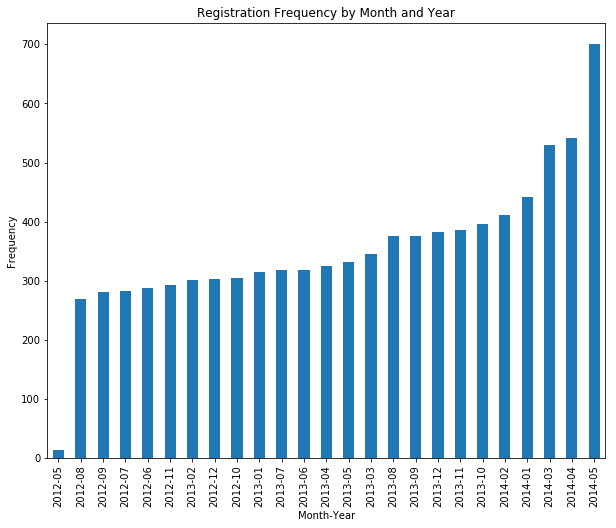

In [266]:
# plot creation times
plt.figure(figsize=(10, 8))

merged_drop.creation_time.value_counts(ascending = True).plot(kind = "bar")
plt.title('Registration Frequency by Month and Year')
plt.xlabel('Month-Year')
plt.ylabel('Frequency')
plt.show()

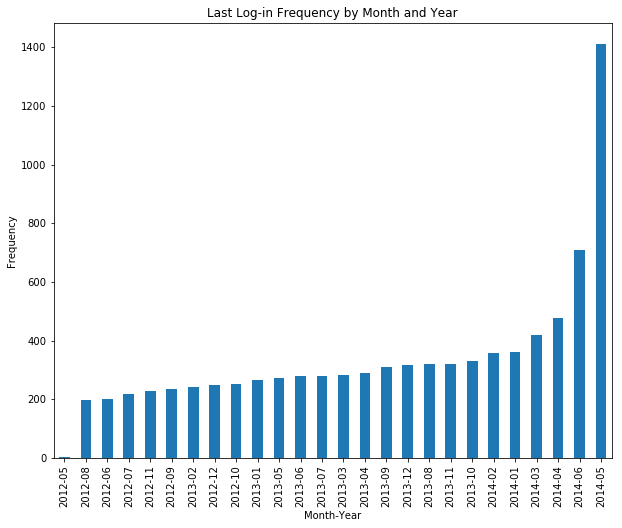

In [267]:
# plot last log-in times
plt.figure(figsize=(10, 8))

merged_drop.last_session_creation_time.value_counts(ascending = True).plot(kind = "bar")
plt.title('Last Log-in Frequency by Month and Year')
plt.xlabel('Month-Year')
plt.ylabel('Frequency')
plt.show()

When viewed by month, both registrations and last log-in times increase in frequency, and they do so in a similar fashion. These two variables may offer essentially the same information, meaning that 1) multicollinearity is very possibly a problem, and 2) there may be a lurking variable (i.e., the amount of time that Relax, Inc., has been operating). 

In [268]:
# check balance of dependent variable
print(merged_drop['adopted'].value_counts())

0    7221
1    1602
Name: adopted, dtype: int64


There is notable imbalance in the dependent variable, so we'll likely need to address this during final analysis. 

In [272]:
#balance for other independent variables

cols = [merged_drop['creation_source'], merged_drop['opted_in_to_mailing_list'], 
        merged_drop['enabled_for_marketing_drip'], merged_drop['referred']]

for col in cols:
    print(col.name)
    print(col.value_counts())
    print()

creation_source
ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64

opted_in_to_mailing_list
0    6597
1    2226
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip
0    7482
1    1341
Name: enabled_for_marketing_drip, dtype: int64

referred
1    4776
0    4047
Name: referred, dtype: int64



In [ ]:
# bar charts for merged_drop['org_id']
# one-hot encoding where needed

In [ ]:
# address multicollinearity if doing logistic regression